<a href="https://colab.research.google.com/github/lfyamagawa/biblioteca/blob/master/FRL_CD_AM2_06_1_Few_shot_com_redes_siamesas_LFY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Few-Shot Learning com Redes Siamesas

## Conteúdo:
- Dataset: Usar o dataset MNIST para simular um problema de few-shot learning.
- Tarefa: Classificar dígitos com apenas 5 exemplos por classe

## Explicação do Código
1. Carregamento e Pré-processamento:
- O dataset MNIST é carregado e normalizado (valores entre 0 e 1).
- Uma dimensão extra é adicionada para compatibilidade com a CNN (shape: (28, 28, 1)).
2. Rede Base:
- A função create_base_network() define uma CNN simples que gera embeddings de 64 dimensões a partir das imagens.
3. Criação de Pares:
- A função create_pairs() gera pares de imagens: positivos (mesmo dígito) e negativos (dígitos diferentes). Aqui, usamos 5 amostras por classe como exemplo de few-shot learning.
4. Rede Siamesa:
- Dois inputs (imagens A e B) são processados pela mesma base_network.
- A distância euclidiana entre os embeddings é calculada.
5. Treinamento:
- A perda contrastiva (contrastive_loss) incentiva embeddings próximos para pares positivos e distantes para pares negativos.
- O modelo é treinado por 5 épocas (suficiente para demonstração).
6. Visualização:
- Os embeddings do conjunto de teste são gerados pela base_network.
- O t-SNE reduz os embeddings de 64 dimensões para 2D, e um gráfico de dispersão mostra os clusters de dígitos.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - loss: 0.3694 - val_loss: 0.2347
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1782 - val_loss: 0.2046
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0858 - val_loss: 0.2008
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0584 - val_loss: 0.1946
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0549 - val_loss: 0.1891
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


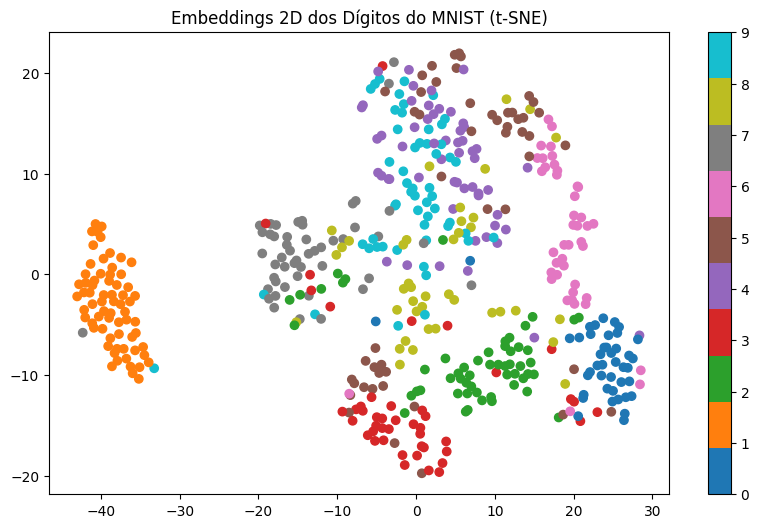

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Carregar o dataset MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizar os dados (valores entre 0 e 1) e adicionar canal para CNN (28, 28, 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # Shape: (10000, 28, 28, 1)

# Função para criar a rede base (CNN compartilhada na rede siamesa)
def create_base_network():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu')  # Embedding de 64 dimensões
    ])
    return model

# Instanciar a rede base
base_network = create_base_network()

# Função para criar pares de imagens (exemplo simplificado para visualização)
def create_pairs(x, y, num_samples_per_class=5):
    pairs = []
    labels = []
    n_classes = 10  # MNIST tem 10 dígitos
    digit_indices = [np.where(y == i)[0] for i in range(n_classes)]

    for d in range(n_classes):
        # Pares positivos (mesmo dígito)
        for i in range(num_samples_per_class):
            idx1, idx2 = np.random.choice(digit_indices[d], 2, replace=False)
            pairs.append([x[idx1], x[idx2]])
            labels.append(1)  # 1 para par positivo

        # Pares negativos (dígitos diferentes)
        for i in range(num_samples_per_class):
            other_digit = (d + np.random.randint(1, n_classes)) % n_classes
            idx1 = np.random.choice(digit_indices[d], 1)[0]
            idx2 = np.random.choice(digit_indices[other_digit], 1)[0]
            pairs.append([x[idx1], x[idx2]])
            labels.append(0)  # 0 para par negativo

    return np.array(pairs), np.array(labels)

# Criar pares para treinamento (exemplo com 5 amostras por classe)
pairs_train, labels_train = create_pairs(x_train, y_train, num_samples_per_class=5)

# Definir a rede siamesa
input_a = layers.Input(shape=(28, 28, 1))
input_b = layers.Input(shape=(28, 28, 1))
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Calcular a distância euclidiana entre os embeddings
distance = layers.Lambda(lambda tensors: tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True))([processed_a, processed_b])

# Criar o modelo siames
siamese_model = models.Model([input_a, input_b], distance)

# Função de perda contrastiva
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    y_true = tf.cast(y_true, tf.float32)
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

# Compilar o modelo
siamese_model.compile(optimizer='adam', loss=contrastive_loss)

# Treinar o modelo (apenas algumas épocas para demonstração)
siamese_model.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train, epochs=5, batch_size=32, validation_split=0.2)

# Visualizar embeddings no conjunto de teste
embeddings = base_network.predict(x_test[:500])  # Usar apenas 500 amostras para visualização rápida
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plotar os embeddings
plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test[:500], cmap='tab10')
plt.colorbar(scatter)
plt.title("Embeddings 2D dos Dígitos do MNIST (t-SNE)")
plt.show()

## 6.1: análise de few-shot com redes siamesas
O modelo está aprendendo rápido, mas pode estar limitado pela quantidade mínima de dados.
A val_loss está estável, o que é bom para few-shot learning.
Próximos passos: Aumentar épocas, adicionar augmentation e verificar se a generalização melhora.